# Plotting a MODIS (.HDF) tile

---

### What does this cover?
1.  Opening MODIS data using `xarray` and `gdal`
2.  Do a quick plot of data; convert/filter as needed
3.  Get projection metadata
4.  Use this to plot on a map

In [1]:
import numpy as np
import xarray
import matplotlib.pyplot as plt
import gdal
import osr
import cartopy

Easier to grab data using `xarray` and then using `gdal` to dig deeper and get HDF file projection info, etc.

Scale factor for MODIS NDVI data is 0.0001 (`1e-4`), and the range of the file is `-2000` to `10000` but should be `-0.2` to `1.0`.  
See user guide here:  https://modis.gsfc.nasa.gov/data/dataprod/mod13.php

Therefore multiply by `1e-8` to get it to a range of `-0.2` to `1.0`

In [2]:
filename = '../data-files/MOD13A2.A2018113.h12v08.006.2018129234917.hdf'
modis_xarray_ds = xarray.open_dataset(filename)

# pull out NDVI data
modis_ndvi = modis_xarray_ds['1 km 16 days NDVI'].values*1e-8

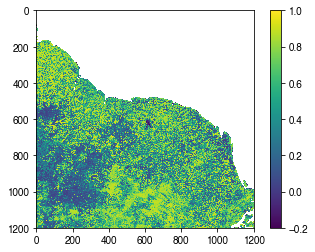

In [3]:
plt.imshow(modis_ndvi, origin='upper', vmin=-.2, vmax=1)
plt.colorbar()

In [4]:
modis_gdal_file = gdal.Open(filename)
modis_gdal_subdatasets = modis_gdal_file.GetSubDatasets()

In [5]:
modis_gdal_ds = gdal.Open(modis_gdal_subdatasets[0][0])
modis_geotrans = modis_gdal_ds.GetGeoTransform()

In [6]:
print(modis_geotrans)

(-6671703.118, 926.625433055833, 0.0, 1111950.519667, 0.0, -926.6254330558334)


In [7]:
modis_proj_info = modis_gdal_ds.GetProjection()
modis_sro = osr.SpatialReference()
modis_sro.ImportFromWkt(modis_proj_info)
print(modis_sro)

PROJCS["unnamed",
    GEOGCS["Unknown datum based upon the custom spheroid",
        DATUM["Not specified (based on custom spheroid)",
            SPHEROID["Custom spheroid",6371007.181,0]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Sinusoidal"],
    PARAMETER["longitude_of_center",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["Meter",1]]


overlay coastlines on native grid

In [8]:
# important to specify data extent
# otherwise matplotlib won't know where the corners are
data_extent = (modis_geotrans[0], \
               modis_geotrans[0] + modis_gdal_ds.RasterXSize*modis_geotrans[1], \
               modis_geotrans[3] + modis_gdal_ds.RasterYSize*modis_geotrans[5], \
               modis_geotrans[3])

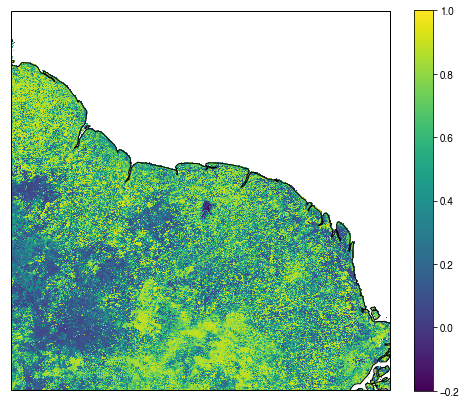

In [11]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)

map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)

fig = plt.figure(figsize=(8.5,7))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(modis_ndvi, extent=(data_extent[0],data_extent[1],data_extent[2],data_extent[3]), origin='upper', transform=data_proj, vmin=-.2, vmax=1)
ax.coastlines(resolution='10m')

plt.colorbar(image)

fig.savefig('../figures/5-modis-with-coastlines.pdf', bbox_inches='tight', transparent=True)

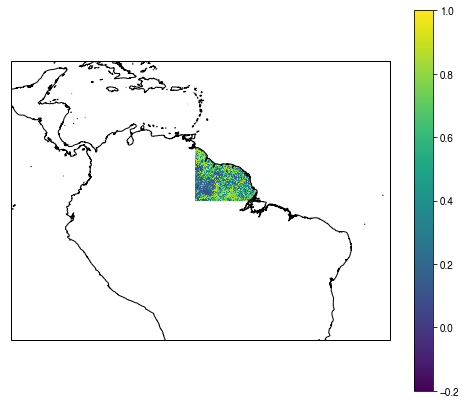

In [10]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)

map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)

fig = plt.figure(figsize=(8.5,7))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(modis_ndvi, extent=(data_extent[0],data_extent[1],data_extent[2],data_extent[3]), origin='upper', transform=data_proj)
ax.coastlines(resolution='10m')

ax.set_extent([270,330,-20,20])

plt.colorbar(image)